In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Activation,
                                    Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras import backend as k

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        if k.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        ## Mike recommendation, up the number of filters at this layer.
        model.add(Conv2D(64, (5, 5), activation='relu',
                         input_shape=inputShape))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        ## Reduce filter size to 3? Input is 16x16
        model.add(Conv2D(128, (3, 3), activation='relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(500, activation='relu'))

        model.add(Dense(classes, activation='sigmoid')) #this is used for binary classes
        #model.add(Dense(classes, activation='softmax')) #this is used for multicalsses
        
        return model

In [18]:
EPOCHS = 200
INIT_LR = 1e-3
BS = 128
CLASS_NUM = 2
norm_size = 64

label_dir = {
    "SN": 0,
    "SC": 1
}
'''
label_dir = {
    "SN": 0,
    "PN": 0,
    "SC": 1,
    "PC": 1
}
'''

'\nlabel_dir = {\n    "SN": 0,\n    "PN": 0,\n    "SC": 1,\n    "PC": 1\n}\n'

In [19]:
#Loading the data
print("[INFO] loading images...")
data = []
labels = []
imagePaths1 = sorted(list(paths.list_images("../Images/Training_Set/SC")))#args["dataset"])))
imagePaths2 = sorted(list(paths.list_images("../Images/Training_Set/SN")))
imagePaths = imagePaths1 + imagePaths2

[INFO] loading images...


In [20]:
imagePaths

['../Images/Training_Set/SC/ELH10_10.jpg',
 '../Images/Training_Set/SC/ELH10_11.jpg',
 '../Images/Training_Set/SC/ELH10_13.jpg',
 '../Images/Training_Set/SC/ELH10_38.jpg',
 '../Images/Training_Set/SC/ELH10_39.jpg',
 '../Images/Training_Set/SC/ELH11_44.jpg',
 '../Images/Training_Set/SC/ELH11_46.jpg',
 '../Images/Training_Set/SC/ELH11_52.jpg',
 '../Images/Training_Set/SC/ELH11_6.jpg',
 '../Images/Training_Set/SC/ELH11_7.jpg',
 '../Images/Training_Set/SC/ELH12_11.jpg',
 '../Images/Training_Set/SC/ELH13_4.jpg',
 '../Images/Training_Set/SC/ELH13_40.jpg',
 '../Images/Training_Set/SC/ELH13_43.jpg',
 '../Images/Training_Set/SC/ELH13_54.jpg',
 '../Images/Training_Set/SC/ELH13_56.jpg',
 '../Images/Training_Set/SC/ELH13_57.jpg',
 '../Images/Training_Set/SC/ELH14_49.jpg',
 '../Images/Training_Set/SC/ELH1_38.jpg',
 '../Images/Training_Set/SC/ELH1_39.jpg',
 '../Images/Training_Set/SC/ELH1_9.jpg',
 '../Images/Training_Set/SC/ELH2_41.jpg',
 '../Images/Training_Set/SC/ELH2_42.jpg',
 '../Images/Training

In [21]:
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath,0)
    image = cv2.resize(image, (norm_size, norm_size))
    image = img_to_array(image)
    data.append(image)

    label_str = imagePath.split(os.path.sep)[-2]

    labels.append(label_dir[label_str])

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [7]:
data.shape

(1609, 64, 64, 1)

In [22]:
# partition the data into 80% training_total and 20% testing
#partition the training_total data into 75% training data and 25% validation data 
(trainX_t, testX, trainY_t, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
(trainX, valX, trainY, valY) = train_test_split(trainX_t, trainY_t, test_size=0.25, random_state=42)

In [14]:
valY.shape

(614,)

In [23]:
#labels = to_categorical(labels, num_classes=CLASS_NUM)
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=CLASS_NUM)
valY = to_categorical(valY, num_classes=CLASS_NUM)
testY = to_categorical(testY, num_classes=CLASS_NUM)

In [24]:
# construct the image generator for data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode="nearest")
train_generator = train_datagen.flow(trainX, trainY, batch_size=BS)

In [25]:
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(valX, valY, batch_size=BS)

In [26]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=norm_size, height=norm_size, depth=1, classes=CLASS_NUM)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"]) #loss="categorical_crossentropy" for multiclasses

[INFO] compiling model...


In [27]:
# train the network
print("[INFO] training network...")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='auto',
                              patience=5, min_lr=0.001) #automatically alter the learning rate
checkpoint = ModelCheckpoint(filepath="mono_binary/0429_mono2class_test1.h5", monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max', period=1)
H = model.fit_generator(train_generator, steps_per_epoch=len(trainX)//BS,
              validation_data=val_generator, validation_steps=len(valX)//BS,
              epochs=EPOCHS, verbose=1, callbacks=[checkpoint,reduce_lr])

[INFO] training network...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 2 steps
Epoch 1/200
5/6 [========================>.....] - ETA: 0s - loss: 0.6897 - accuracy: 0.5602
Epoch 00001: val_accuracy improved from -inf to 0.60156, saving model to mono_binary/0429_mono2class_test1.h5
6/6 [==============================] - 4s 646ms/step - loss: 0.6904 - accuracy: 0.5622 - val_loss: 0.6783 - val_accuracy: 0.6016
Epoch 2/200
5/6 [========================>.....] - ETA: 0s - loss: 0.6896 - accuracy: 0.5661
Epoch 00002: val_accuracy did not improve from 0.60156
6/6 [==============================] - 3s 554ms/step - loss: 0.6887 - accuracy: 0.5829 - val_loss: 0.6852 - val_accuracy: 0.6016
Epoch 3/200
5/6 [========================>.....] - ETA: 0s - loss: 0.6793 - accuracy: 0.5953
Epoch 00003: val_accuracy did not improve from 0.60156
6/6 [==============================] - 3s 579ms/step - loss: 0.6823 - accuracy: 0.5922 - val_loss: 0.6712 - val_accuracy: 0.60

Epoch 28/200
5/6 [========================>.....] - ETA: 0s - loss: 0.5953 - accuracy: 0.7056
Epoch 00028: val_accuracy did not improve from 0.77344
6/6 [==============================] - 4s 613ms/step - loss: 0.5932 - accuracy: 0.7119 - val_loss: 0.5932 - val_accuracy: 0.6855
Epoch 29/200
5/6 [========================>.....] - ETA: 0s - loss: 0.5825 - accuracy: 0.6782
Epoch 00029: val_accuracy did not improve from 0.77344
6/6 [==============================] - 4s 600ms/step - loss: 0.5709 - accuracy: 0.6965 - val_loss: 0.5117 - val_accuracy: 0.7383
Epoch 30/200
5/6 [========================>.....] - ETA: 0s - loss: 0.5663 - accuracy: 0.7039
Epoch 00030: val_accuracy did not improve from 0.77344
6/6 [==============================] - 4s 606ms/step - loss: 0.5687 - accuracy: 0.7025 - val_loss: 0.5143 - val_accuracy: 0.7266
Epoch 31/200
5/6 [========================>.....] - ETA: 0s - loss: 0.5565 - accuracy: 0.7185
Epoch 00031: val_accuracy did not improve from 0.77344
6/6 [============

5/6 [========================>.....] - ETA: 0s - loss: 0.3703 - accuracy: 0.8383
Epoch 00056: val_accuracy did not improve from 0.86133
6/6 [==============================] - 4s 649ms/step - loss: 0.3723 - accuracy: 0.8405 - val_loss: 0.3596 - val_accuracy: 0.8594
Epoch 57/200
5/6 [========================>.....] - ETA: 0s - loss: 0.3876 - accuracy: 0.8347
Epoch 00057: val_accuracy improved from 0.86133 to 0.86328, saving model to mono_binary/0429_mono2class_test1.h5
6/6 [==============================] - 4s 660ms/step - loss: 0.3863 - accuracy: 0.8329 - val_loss: 0.3411 - val_accuracy: 0.8633
Epoch 58/200
5/6 [========================>.....] - ETA: 0s - loss: 0.3585 - accuracy: 0.8411
Epoch 00058: val_accuracy did not improve from 0.86328
6/6 [==============================] - 4s 618ms/step - loss: 0.3549 - accuracy: 0.8496 - val_loss: 0.3533 - val_accuracy: 0.8438
Epoch 59/200
5/6 [========================>.....] - ETA: 0s - loss: 0.3626 - accuracy: 0.8391
Epoch 00059: val_accuracy d

Epoch 85/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2636 - accuracy: 0.8961
Epoch 00085: val_accuracy did not improve from 0.89258
6/6 [==============================] - 4s 626ms/step - loss: 0.2675 - accuracy: 0.8913 - val_loss: 0.2896 - val_accuracy: 0.8887
Epoch 86/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2882 - accuracy: 0.8548
Epoch 00086: val_accuracy did not improve from 0.89258
6/6 [==============================] - 4s 607ms/step - loss: 0.2888 - accuracy: 0.8616 - val_loss: 0.2833 - val_accuracy: 0.8809
Epoch 87/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2767 - accuracy: 0.8782
Epoch 00087: val_accuracy did not improve from 0.89258
6/6 [==============================] - 4s 611ms/step - loss: 0.2651 - accuracy: 0.8890 - val_loss: 0.2811 - val_accuracy: 0.8750
Epoch 88/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2736 - accuracy: 0.8895
Epoch 00088: val_accuracy did not improve from 0.89258
6/6 [============

Epoch 114/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2545 - accuracy: 0.9081
Epoch 00114: val_accuracy did not improve from 0.90820
6/6 [==============================] - 4s 633ms/step - loss: 0.2623 - accuracy: 0.9011 - val_loss: 0.2915 - val_accuracy: 0.8848
Epoch 115/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2914 - accuracy: 0.8726
Epoch 00115: val_accuracy did not improve from 0.90820
6/6 [==============================] - 4s 639ms/step - loss: 0.2992 - accuracy: 0.8710 - val_loss: 0.3185 - val_accuracy: 0.8535
Epoch 116/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2851 - accuracy: 0.8871
Epoch 00116: val_accuracy did not improve from 0.90820
6/6 [==============================] - 4s 685ms/step - loss: 0.2778 - accuracy: 0.8917 - val_loss: 0.3112 - val_accuracy: 0.8730
Epoch 117/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2511 - accuracy: 0.9032
Epoch 00117: val_accuracy did not improve from 0.90820
6/6 [========

Epoch 144/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2161 - accuracy: 0.9161
Epoch 00144: val_accuracy did not improve from 0.90820
6/6 [==============================] - 3s 571ms/step - loss: 0.2131 - accuracy: 0.9211 - val_loss: 0.2552 - val_accuracy: 0.8945
Epoch 145/200
5/6 [========================>.....] - ETA: 0s - loss: 0.1938 - accuracy: 0.9242
Epoch 00145: val_accuracy did not improve from 0.90820
6/6 [==============================] - 3s 572ms/step - loss: 0.1997 - accuracy: 0.9184 - val_loss: 0.2642 - val_accuracy: 0.9023
Epoch 146/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2006 - accuracy: 0.9218
Epoch 00146: val_accuracy did not improve from 0.90820
6/6 [==============================] - 3s 580ms/step - loss: 0.1851 - accuracy: 0.9298 - val_loss: 0.2633 - val_accuracy: 0.8945
Epoch 147/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2131 - accuracy: 0.9153
Epoch 00147: val_accuracy improved from 0.90820 to 0.91016, saving m

Epoch 173/200
5/6 [========================>.....] - ETA: 0s - loss: 0.1937 - accuracy: 0.9234
Epoch 00173: val_accuracy did not improve from 0.91797
6/6 [==============================] - 4s 588ms/step - loss: 0.2030 - accuracy: 0.9205 - val_loss: 0.2512 - val_accuracy: 0.9141
Epoch 174/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 0.9258
Epoch 00174: val_accuracy did not improve from 0.91797
6/6 [==============================] - 3s 582ms/step - loss: 0.1887 - accuracy: 0.9305 - val_loss: 0.2625 - val_accuracy: 0.8945
Epoch 175/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2065 - accuracy: 0.9234
Epoch 00175: val_accuracy did not improve from 0.91797
6/6 [==============================] - 4s 603ms/step - loss: 0.2159 - accuracy: 0.9151 - val_loss: 0.2557 - val_accuracy: 0.9023
Epoch 176/200
5/6 [========================>.....] - ETA: 0s - loss: 0.2112 - accuracy: 0.9180
Epoch 00176: val_accuracy did not improve from 0.91797
6/6 [========

In [14]:
from tensorflow.keras.models import load_model

best_model = load_model('poly_binary/0429_poly2class_test1.h5')

In [15]:
test_loss, test_acc=best_model.evaluate(testX,testY)
test_acc

322/322 [==============================] - 1s 2ms/sample - loss: 0.3119 - accuracy: 0.8851


0.88509315

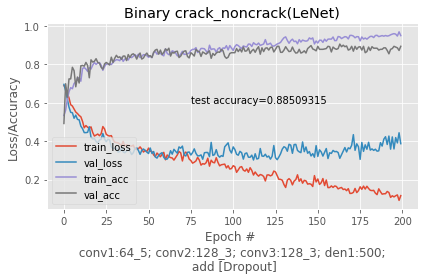

In [17]:
%matplotlib inline
# save the model to disk
#print("[INFO] serializing network...")

#
# plot the training loss and accuracy

plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Binary crack_noncrack(LeNet)")
#plt.xlabel("Epoch #") 
plt.xlabel("Epoch # \n conv1:64_5; conv2:128_3; conv3:128_3; den1:500; \n add [Dropout]")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(75,0.6,"test accuracy="+str(test_acc))
#plt.savefig("0418_2classes.png",dpi=600)
plt.savefig("poly_binary/0429_poly2class_test1",dpi=600)
#plt.show()


614/614 [==============================] - 0s 639us/sample - loss: 0.4131 - accuracy: 0.8844


SyntaxError: invalid token (<ipython-input-11-a2b0bd48e395>, line 1)